In [1]:
root_dir = '/home2/glee/dissertation/1_tech_gen_impact/Transformer/Tech_Gen/'
import sys
sys.path.append(root_dir)

import copy
import gc
import os
import argparse
import math
import time
import pickle
import re
import multiprocess as mp
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
sys.path.append("/share/tml_package")
from tml import utils
from scipy import io
from tqdm import tqdm
from collections import OrderedDict

import torch
from torch.nn import functional as F
from torch.nn import DataParallel as DP
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
from accelerate import Accelerator
import pytorch_model_summary

import optuna
from optuna.samplers import RandomSampler, TPESampler
from optuna.integration import SkoptSampler

import numpy as np
import pandas as pd
import scipy.stats
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from data import TechDataset, CVSampler
from models import Transformer
from train_utils import EarlyStopping, perf_eval, objective_cv, build_model, train_model, validate_model_mp
from utils import token2class, DotDict

from cleantext.sklearn import CleanTransformer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# PART 1: Configuration

In [2]:
mp.set_start_method("spawn")

In [9]:
args = argparse.Namespace(
    data_type="claim",
    data_file = "collection_[H01L,H10][2017].csv",
    target_ipc="H01L",
    pred_type="regression",
    n_TC = 5,
    use_pretrained_tokenizer=False,
    do_train=None,
    do_tune=None,
    n_folds=None,
    max_epochs=2,
    use_accelerator=None,
    do_save=False,
    n_gpus=3,
    light=True,
    config_file=None,
    eval_train_set=False)

data_dir = os.path.join(root_dir, "data")
model_dir = os.path.join(root_dir, "models")
result_dir = os.path.join(root_dir, "results")
config_dir = os.path.join(root_dir, "configs")

if args.config_file is not None:
    config_file = args.config_file
else:
    config_file = os.path.join(config_dir, "configs_light.json") if args.light else os.path.join(config_dir, "configs.json")
configs = DotDict().load(config_file)
org_config_keys = {key: list(configs[key].keys()) for key in configs.keys()}

instant_configs = {key: value for (key, value) in vars(args).items() if value is not None} # if any argument passed when main.py executed
instant_configs_for_update = {configkey: {key: value for (key,value) in instant_configs.items() if key in org_config_keys[configkey]} for configkey in org_config_keys.keys()}
for key, value in configs.items():
    value.update(instant_configs_for_update[key])

regex_ipc = re.compile('[A-Z](?![\\D])')
if regex_ipc.match(configs.data.target_ipc) is None:
    configs.data.update({"target_ipc": "ALL"})
elif len(configs.data.target_ipc) > 5:
    configs.data.update({"target_ipc": configs.data.target_ipc[:4]})

if configs.model.model_type == "enc-pred-dec":
    configs.train.loss_weights["recon"] = configs.train.loss_weights["recon"] / sum(configs.train.loss_weights.values())
    configs.train.loss_weights["y"] = 1 - configs.train.loss_weights["recon"]
elif configs.model.model_type == "enc-pred":
    configs.train.loss_weights = {"recon": 0, "y": 1}
elif configs.model.model_type == "enc-dec":
    configs.train.loss_weights = {"recon": 1, "y": 0}

if configs.train.use_accelerator:
    accelerator = Accelerator()
    device_ids = list(range(torch.cuda.device_count()))
    device = accelerator.device

    configs.train.update({"accelerator": accelerator})
else:
    if torch.cuda.is_available():
        device_ids = list(range(torch.cuda.device_count()))
        gpu_usages = [np.sum([float(usage.split("uses")[-1].replace(" ","").replace("MB","")) for usage in torch.cuda.list_gpu_processes(id).split("GPU memory") if not usage=="" and "no processes are running" not in usage]) for id in device_ids]
        device_ids = np.argsort(gpu_usages)[:configs.train.n_gpus]
        device_ids = list(map(lambda x: torch.device('cuda', x),list(device_ids)))
        device = device_ids[0] # main device
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')
        device_ids = []

configs.data.update({"root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "result_dir": result_dir})
configs.train.update({"device": device,
                        "device_ids": device_ids,
                        "root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "use_keywords": configs.data.use_keywords,
                        "early_stop_patience": int(0.3*configs.train.max_epochs)})
configs.model.update({"device": device,
                        "device_ids": device_ids,
                        "n_directions": 2 if configs.model.bidirec else 1,
                        "use_accelerator": configs.train.use_accelerator})

## Set hyperparameters for model training (To be TUNED)
if configs.train.do_train and configs.train.do_tune:
    n_layers = configs.model.n_layers = None
    d_embedding = configs.model.d_embedding = None
    d_hidden = configs.model.d_hidden = None
    d_latent = None
    learning_rate = configs.train.learning_rate = None
    batch_size = configs.train.batch_size = None
    config_name = "HPARAM_TUNING"
    final_model_path = None
else:
    n_layers = configs.model.n_layers
    d_embedding = configs.model.d_embedding
    d_hidden = configs.model.d_hidden
    d_latent = configs.model.n_enc_seq * configs.model.d_hidden

    key_components = {"data": ["target_ipc", "pred_type", "max_seq_len", "vocab_size"], "model": ["n_layers", "d_hidden", "d_embedding", "d_ff", "n_head", "d_head"], "train": ["learning_rate", "batch_size", "max_epochs"]}
    config_name = ""
    for key in key_components.keys():
        for component in key_components[key]:
            config_name += "["+str(configs[key][component])+component+"]"
    final_model_path = os.path.join(model_dir, f"[Final_model]{config_name}.ckpt")

configs.model.update({"d_latent": d_latent})
configs.train.update({"config_name": config_name,
                        "final_model_path": final_model_path})


# PART 2: Dataset setting

In [10]:
tstart = time.time()
dataset_config_name = "-".join([str(key)+"="+str(value) for (key,value) in configs.data.items() if key in org_config_keys["data"]])
dataset_path = os.path.join(data_dir, "pickled_dataset", "[tech_dataset]"+dataset_config_name+".pickle")
if os.path.exists(dataset_path) and args.do_save is False:
    print("Load pickled dataset...")
    with open(dataset_path, "rb") as f:
        tech_dataset = pickle.load(f)   # Load pickled dataset if dataset with same configuration already saved
    print("Pickled dataset loaded")
else:
    print("Make dataset...")
    tech_dataset = TechDataset(configs.data)
    with open(dataset_path, "wb") as f:
        tech_dataset.rawdata = None
        pickle.dump(tech_dataset, f)
tend = time.time()
print(f"{np.round(tend-tstart,4)} sec elapsed for loading patents for class [{configs.data.target_ipc}]")

configs.model.update({"tokenizer": tech_dataset.tokenizer,
                        "n_enc_vocab": tech_dataset.tokenizer.get_vocab_size(),
                        "n_dec_vocab": tech_dataset.tokenizer.get_vocab_size(),
                        "n_enc_seq": tech_dataset.max_seq_len,
                        "n_dec_seq": tech_dataset.max_seq_len,
                        "n_outputs": 1 if configs.data.pred_type=="regression" else tech_dataset.n_outputs,
                        "i_padding": tech_dataset.tokenizer.token_to_id("<PAD>")})
configs.model.update({"d_latent": configs.model.n_enc_seq * configs.model.d_hidden})

Make dataset...



Tokenizer is trained and saved
88.4263 sec elapsed for loading patents for class [H01L]


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

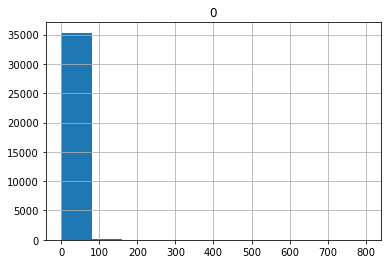

In [11]:
pd.DataFrame(tech_dataset.Y).hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

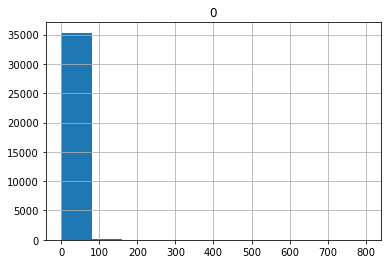

In [50]:
pd.DataFrame(tech_dataset.Y[tech_dataset.Y<801]).hist()

In [54]:
tech_dataset.Y[tech_dataset.Y<2].shape

(25643,)

In [64]:
for i in range(1, 6):
    print(str(i)+":",str(np.round((tech_dataset.Y[tech_dataset.Y>=i].shape[0] / len(tech_dataset.Y))*100, 2))+"%")

1: 47.22%
2: 27.61%
3: 17.78%
4: 12.35%
5: 9.26%


In [56]:
9782/35427

0.27611708583848477

In [39]:
tech_dataset.Y[np.where(np.digitize(tech_dataset.Y, bins=[4], right=True)==1)[0]].shape

(3280,)

# PART 3: Training

In [48]:
sampler = CVSampler(tech_dataset, n_folds=configs.train.n_folds, test_ratio=0.1, stratify=True)
cv_idx = sampler.get_idx_dict()
print(f"#Samples\nTrain: {len(cv_idx[0]['train'])}, Validation: {len(cv_idx[0]['val'])}, Test: {len(cv_idx[0]['test'])}")

#Samples
Train: 25505, Validation: 6377, Test: 3543


## PART 3-1: Hyperparameter tuning

In [7]:
if configs.train.do_tune:
    configs.train.update({"tuned_model_path": os.path.join(model_dir,"hparam_tuning")})
    optuna_obj = lambda trial: objective_cv(trial, dataset=tech_dataset, cv_idx=cv_idx, model_params=configs.model, train_params=configs.train)

    opt_sampler = TPESampler()
    study = optuna.create_study(direction='minimize')
    study.optimize(optuna_obj, n_trials=configs.train.n_trials, gc_after_trial=True)
    best_params = study.best_trial.params

    print(f"Best trial:\n  CrossEntropyLoss: {study.best_trial.value}\n  Params:")
    for k, v in best_params.items():
        print(f"    {k}: {v}")

    configs.train.update({k: v for k,v in best_params.items() if k in configs.train.keys()})
    configs.model.update({k: v for k,v in best_params.items() if k in configs.model.keys()})
    config_name = f"{configs.model.n_layers}layers_{configs.model.d_embedding}emb_{configs.model.d_hidden}hid_{configs.model.n_directions}direc_{np.round(configs.train.learning_rate, 4)}lr_{configs.train.batch_size}batch_{configs.train.max_epochs}ep"
    final_model_path = os.path.join(model_dir, f"[Final_model][{configs.data.target_ipc}]{config_name}.ckpt")

## PART 3-2: Dataset construction and model training

In [49]:
## Construct datasets
train_idx = cv_idx[0]['train']
val_idx = cv_idx[0]['val']
test_idx = cv_idx[0]['test']
whole_idx = np.concatenate([train_idx, val_idx])

train_dataset = Subset(tech_dataset, train_idx)
val_dataset = Subset(tech_dataset, val_idx)
test_dataset = Subset(tech_dataset, test_idx)
whole_dataset = Subset(tech_dataset, whole_idx)

train_loader = DataLoader(train_dataset, batch_size=configs.train.batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=configs.train.batch_size if len(val_idx)>configs.train.batch_size else len(val_idx), shuffle=True, num_workers=4, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=configs.train.batch_size if len(test_idx)>configs.train.batch_size else len(test_idx), shuffle=False, num_workers=4)
whole_loader = DataLoader(whole_dataset, batch_size=configs.train.batch_size, shuffle=False, num_workers=4)

## Load best model or build model
final_model = build_model(configs.model, tokenizer=tech_dataset.tokenizer)

In [50]:
with torch.no_grad():
    x_input, *_ = tech_dataset.__getitem__(0)
    x_input = torch.tensor(x_input, device=device).unsqueeze(0)
    print(pytorch_model_summary.summary(final_model.module, torch.zeros(x_input.shape, device=device, dtype=torch.long), torch.zeros(x_input.shape, device=device, dtype=torch.long), show_input=True, max_depth=None, show_parent_layers=True))

--------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                   Parent Layers       Layer (type)          Input Shape         Param #     Tr. Param #
                                                             Transformer/Encoder        Embedding-1             [1, 256]          80,000          80,000
                                                             Transformer/Encoder        Embedding-2             [1, 256]           8,224               0
                             Transformer/Encoder/EncoderLayer/MultiHeadAttention           Linear-3         [1, 256, 32]           4,224           4,224
                             Transformer/Encoder/EncoderLayer/MultiHeadAttention           Linear-4         [1, 256, 32]           4,224           4,224
                             Transformer/Encoder/EncoderLayer/MultiHeadAttention  

In [51]:
## Train model
if configs.train.do_tune:
    best_states = torch.load(os.path.join(configs.train.tuned_model_path,f"[HPARAM_TUNING]{study.best_trial.number}trial.ckpt"))
    converted_states = OrderedDict()
    for k, v in best_states.items():
        if 'module' not in k:
            k = 'module.'+k
        else:
            k = k.replace('features.module.', 'module.features.')
        converted_states[k] = v
    final_model.load_state_dict(converted_states)
else:
    final_model = train_model(final_model, train_loader, val_loader, configs.model, configs.train)
torch.save(final_model.state_dict(), final_model_path) # Finalize
torch.cuda.empty_cache()

Epoch 1
-------------------------


199it [00:38,  5.17it/s]


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                maxwell_sgemm_128x64_nn         0.00%       0.000us         0.00%       0.000us       0.000us       7.621ms        20.58%       7.621ms     317.542us           0 b           0 b           0 b           0 

50it [00:01, 38.39it/s]


Epoch: 01 | Time: 0m 40s
Avg train loss: 0.692499 (recon loss: 0.000000, y loss: 0.692499)
Avg val loss: 0.692230 (recon loss: 0.000000, y loss: 0.692230)

Validation loss decreased (inf --> 0.692230).  Saving model ...

Epoch 2
-------------------------


199it [00:31,  6.24it/s]


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                maxwell_sgemm_128x64_nn         0.00%       0.000us         0.00%       0.000us       0.000us       7.610ms        20.56%       7.610ms     317.083us           0 b           0 b           0 b           0 

50it [00:01, 39.51it/s]


Epoch: 02 | Time: 0m 34s
Avg train loss: 0.689878 (recon loss: 0.000000, y loss: 0.689878)
Avg val loss: 0.685535 (recon loss: 0.000000, y loss: 0.685535)

Validation loss decreased (0.692230 --> 0.685535).  Saving model ...



In [32]:
X, X_keywords, Y = next(iter(train_loader))
src, trg, y = X_keywords.to(device), X.to(device), Y.to(device)

In [36]:
trg

tensor([[   0,   18,   15,  ...,    1,    1,    1],
        [   0,   18,   15,  ...,  282, 2118,    2],
        [   0,   18,   15,  ...,  331,   13,    2],
        ...,
        [   0,   18,   15,  ...,    1,    1,    1],
        [   0,   18,   15,  ...,    1,    1,    1],
        [   0,   18,   15,  ...,    1,    1,    1]], device='cuda:1')

In [39]:
y

tensor([1, 2, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 2, 1, 0,
        0, 0, 2, 1, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 2, 1, 0,
        2, 0, 0, 1, 2, 0, 0, 1], device='cuda:1')

In [40]:
tech_dataset.n_outputs

3

In [44]:
outputs = final_model(src, trg[:,:-1])

In [46]:
outputs_recon = [output[0] for output in outputs] # outputs_recon: n_gpus *

## PART 3-3: Training evaluation

In [ ]:
if args.eval_train_set:
    ## Evaluation on train dataset
    print("Validate model on train dataset")
    # trues_recon_train, preds_recon_train, trues_y_train, preds_y_train = validate_model(final_model, whole_loader, configs.model, configs.train)
    val_res_train = validate_model_mp(final_model, whole_dataset, mp=mp, model_params=configs.model, train_params=configs.train)
    trues_recon_train = np.concatenate([res["recon"]["true"] for res in val_res_train.values()])
    preds_recon_train = np.concatenate([res["recon"]["pred"] for res in val_res_train.values()])
    trues_y_train = np.concatenate([res["y"]["true"] for res in val_res_train.values()])
    preds_y_train = np.concatenate([res["y"]["pred"] for res in val_res_train.values()])

    eval_recon_train = perf_eval("TRAIN_SET", trues_recon_train, preds_recon_train, configs=configs, pred_type='generative', tokenizer=final_model.module.tokenizer)
    eval_recon_train = perf_eval("TRAIN_SET", trues_recon_train, preds_recon_train, configs=configs, pred_type='generative', tokenizer=final_model.module.tokenizer)
    eval_y_train = perf_eval("TRAIN_SET", trues_y_train, preds_y_train, configs=configs, pred_type=configs.data.pred_type)
    if configs.data.pred_type == "classification":
        eval_y_train, confmat_y_train = eval_y_train
else:
    eval_recon_train = eval_y_train = None

## Evaluation on test dataset
print("Validate model on test dataset")
# trues_recon_test, preds_recon_test, trues_y_test, preds_y_test = validate_model(final_model, test_loader, configs.model, configs.train)
val_res_test = validate_model_mp(final_model, test_dataset, mp=mp, batch_size=64, model_params=configs.model, train_params=configs.train)
trues_recon_test = np.concatenate([res["recon"]["true"] for res in val_res_test.values()])
preds_recon_test = np.concatenate([res["recon"]["pred"] for res in val_res_test.values()])
trues_y_test = np.concatenate([res["y"]["true"] for res in val_res_test.values()])
preds_y_test = np.concatenate([res["y"]["pred"] for res in val_res_test.values()])

eval_recon_test = perf_eval("TEST_SET", trues_recon_test, preds_recon_test, configs=configs,  pred_type='generative', tokenizer=final_model.module.tokenizer)
eval_y_test = perf_eval("TEST_SET", trues_y_test, preds_y_test, configs=configs, pred_type=configs.data.pred_type)
if configs.data.pred_type == "classification":
    eval_y_test, confmat_y_test = eval_y_test

eval_recon_res = pd.concat([eval_recon_train, eval_recon_test], axis=0)
eval_y_res = pd.concat([eval_y_train, eval_y_test], axis=0)
if configs.data.pred_type == "classification":
    confmat_y_res = pd.concat([confmat_y_train, confmat_y_test], axis=0)


In [ ]:
raise

# (temp) Pre-trained model experiment

In [ ]:
from transformers import BartTokenizer, BartModel, BartForConditionalGeneration

In [12]:
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig

In [56]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)
    
    def forward(self, input_ids, mask):
        x = self.l1(input_ids=input_ids, attention_mask=mask)
        hidden_state = x[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        
        return output, hidden_state

In [65]:
m = BERTClass().to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [66]:
out = tokenizer(tech_dataset.data['claims'][:100].tolist(), add_special_tokens=True, max_length=256, padding="max_length", truncation=True)

In [67]:
inputs = {"input_ids": torch.tensor(out.input_ids, dtype=torch.long, device=device),
         "mask": torch.tensor(out.attention_mask, dtype=torch.long, device=device)}

In [68]:
temp = m(inputs["input_ids"], inputs["mask"])

In [71]:
temp[1].shape

torch.Size([100, 256, 768])

In [73]:
device = torch.device("cuda", 0)

In [75]:
print(pytorch_model_summary.summary(m.to(device), torch.zeros(inputs["input_ids"].shape, device=device, dtype=torch.long), torch.zeros(inputs["input_ids"].shape, device=device, dtype=torch.long), show_input=True, max_depth=None, show_parent_layers=True))

-----------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                   Parent Layers       Layer (type)             Input Shape         Param #     Tr. Param #
                                            BERTClass/DistilBertModel/Embeddings        Embedding-1              [100, 256]      23,440,896      23,440,896
                                            BERTClass/DistilBertModel/Embeddings        Embedding-2                [1, 256]         393,216         393,216
                                            BERTClass/DistilBertModel/Embeddings        LayerNorm-3         [100, 256, 768]           1,536           1,536
                                            BERTClass/DistilBertModel/Embeddings          Dropout-4         [100, 256, 768]               0               0
   BERTClass/DistilBertModel/Transformer/TransformerBlock/MultiH